### Курсовая работа по курсу "Рекомендательные системы"

- Целевая метрика precision@5
- Бейзлайн решения - [MainRecommender](https://github.com/geangohn/recsys-tutorial/blob/master/src/recommenders.py)
- Сдаем ссылку на github с решением. На github должен быть файл recommendations.csv (user_id | [rec_1, rec_2, ...] с рекомендациями. rec_i - реальные id item-ов (из retail_train.csv)

In [248]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [58]:
data = pd.read_csv('data/retail_train.csv')
item_features = pd.read_csv('data/product.csv')
user_features = pd.read_csv('data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [59]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=3000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 3001


In [60]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data['user_id'].nunique()} Items: {df_data['item_id'].nunique()}")

In [61]:
# общие пользователи
common_users = list(set(data_train_lvl_1.user_id.values)&(set(data_val_lvl_1.user_id.values))&set(data_val_lvl_2.user_id.values))

data_train_lvl_1 = data_train_lvl_1[data_train_lvl_1.user_id.isin(common_users)]
data_val_lvl_1 = data_val_lvl_1[data_val_lvl_1.user_id.isin(common_users)]
data_train_lvl_2 = data_train_lvl_2[data_train_lvl_2.user_id.isin(common_users)]
data_val_lvl_2 = data_val_lvl_2[data_val_lvl_2.user_id.isin(common_users)]

print_stats_data(data_train_lvl_1,'train_lvl_1')
print_stats_data(data_val_lvl_1,'val_lvl_1')
print_stats_data(data_train_lvl_2,'train_lvl_2')
print_stats_data(data_val_lvl_2,'val_lvl_2')

train_lvl_1
Shape: (784420, 13) Users: 1915 Items: 3001
val_lvl_1
Shape: (163261, 12) Users: 1915 Items: 27118
train_lvl_2
Shape: (163261, 12) Users: 1915 Items: 27118
val_lvl_2
Shape: (115989, 12) Users: 1915 Items: 24042


#### MainRecommender

In [62]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3001 [00:00<?, ?it/s]

In [63]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."


In [64]:
def do_recommend(model, func, n, k):
    
    func_dic = {
        'get_als_recommendations': model.get_als_recommendations,
        'get_own_recommendations': model.get_own_recommendations,
        'get_similar_items_recommendation': model.get_similar_items_recommendation,
        'get_similar_users_recommendation': model.get_similar_users_recommendation
    }
    
    try:
        result = func_dic[func](n, k)
    
    except (IndexError, ValueError) as e:
        
        result = recommender._extend_with_top_popular([], k)
    
    return result

In [65]:
%%time 

k = 50
result_lvl_1['own'] = result_lvl_1['user_id'].apply(lambda x: 
                                                    recommender.get_own_recommendations(x, k))
result_lvl_1.head(2)

CPU times: user 6.71 s, sys: 332 ms, total: 7.04 s
Wall time: 7.13 s


,user_id,actual,own
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 9655212, 1124029, 8..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[13003092, 972416, 1084036, 995598, 5569792, 1..."


In [66]:
result_lvl_1.apply(lambda row: precision_at_k(row['own'], row['actual'], k=5), axis=1).mean()

0.20553524804177548

### 2-lvl model

In [67]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

users_lvl_2.head(2)

,user_id
0,2070
1,2021


In [68]:
users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=k))
users_lvl_2.head(4)

,user_id,candidates
0,2070,"[1105426, 944588, 1092937, 1008814, 917033, 83..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."
2,1753,"[963686, 1057168, 9553382, 942166, 935993, 106..."
3,2120,"[1029743, 1106523, 5569230, 916122, 1070820, 8..."


In [69]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)

users_lvl_2.head(4)

,user_id,item_id
0,2070,1105426
0,2070,944588
0,2070,1092937
0,2070,1008814


In [70]:
targets_lvl_2 = data_train_lvl_2.copy()
targets_lvl_2['target'] = 1  # тут только покупки 

In [71]:
targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

In [72]:
targets_lvl_2['target'].fillna(0, inplace= True)

In [73]:
targets_lvl_2['target'].mean()

0.1249599519423308

### Catboost

In [18]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [19]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [80]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,basket_id,day,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,944588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LUNCHMEAT,HAM,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


#### FE

In [172]:
def gen_new_user_feachs(df):
    
    # добавим средний чек по каждому пользователю
    basket_sum = df.groupby(['user_id', 'basket_id'], as_index=False).agg({'sales_value': 'sum'})
    basket_mean = basket_sum.groupby(['user_id'], as_index=False).agg({'sales_value': 'mean'}).\
                rename(columns={'sales_value':'basket_mean'})

    df = df.merge(basket_mean, on='user_id', how='left')

    # кол-во покупок в каждой категрии по пользователям
    user_cat_sale_count = df.groupby(['user_id', 'commodity_desc'], as_index=True).\
                            agg({'commodity_desc': 'count'}).\
                            rename(columns={'commodity_desc':'commodity_count'}).reset_index()

    df = df.merge(user_cat_sale_count, on=['user_id', 'commodity_desc'], how='left')
    
    # Средняя сумма покупки 1 товара в каждой категории
    mean_good_price_cat = df.groupby(['user_id', 'commodity_desc'], as_index=True).\
                agg({'sales_value': 'mean'}).rename(columns={'sales_value':'mean_good_price_cat'}).reset_index()

    df = df.merge(mean_good_price_cat, on=['user_id', 'commodity_desc'], how='left')
    
    # Частотность покупок раз/неделя
    sales_count = df.groupby(['user_id', 'week_no'], as_index=True).\
                agg({'basket_id': 'count'}).rename(columns={'basket_id': 'sales_week_count'}).reset_index()

    df = df.merge(sales_count, on=['user_id', 'week_no'], how='left')
    
    
    # Кол-во покупок утром/днем/вечером
    df['trans_time'] = df['trans_time']/100
    df.loc[(df['trans_time'] <= 12.0) & (df['trans_time'] > 5.0), 'period'] = 'morning' 
    df.loc[(df['trans_time'] <= 18.0) & (df['trans_time'] > 12.0), 'period'] = 'afternoon' 
    df.loc[(df['trans_time'] <= 22.0) & (df['trans_time'] > 18.0), 'period'] = 'evening' 
    df.loc[(df['trans_time'] <= 5.0) | (df['trans_time'] > 22.0), 'period'] = 'night' 

    period_sale_count = df.groupby(['user_id', 'period'], as_index=True).agg({'basket_id': 'count'}).\
                        rename(columns={'basket_id': 'period_sale_count'})

    df = df.merge(period_sale_count, on=['user_id', 'period'], how='left')
    
    return df

In [32]:
def gen_new_item_feachs(df):
    
    # средняя цена товара в категории / стоимость товара к средней стоимости по категории
    commodity_mean_price = df.groupby(['commodity_desc', 'item_id'], as_index=True).\
                            agg({'sales_value': 'mean'}).\
                            rename(columns={'sales_value': 'item_price'}).\
                            groupby(['commodity_desc']).agg({'item_price': 'mean'}).reset_index()

    df = df.merge(commodity_mean_price, on='commodity_desc', how='left')
    df['price_to_cat'] = df[['sales_value', 'item_price']].\
                        apply(lambda row: row['sales_value']/row['item_price'], axis=1)
    
    
    return df

In [176]:
X_train = targets_lvl_2.copy().drop('target', axis=1)
y_train = targets_lvl_2[['target']].copy()

In [177]:
X_train = gen_new_user_feachs(X_train)
X_train = gen_new_item_feachs(X_train)

In [178]:
X_train.columns

Index(['user_id', 'item_id', 'basket_id', 'day', 'quantity', 'sales_value',
       'store_id', 'retail_disc', 'trans_time', 'week_no', 'coupon_disc',
       'coupon_match_disc', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
       'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', 'kid_category_desc', 'own_proba',
       'basket_mean', 'commodity_count', 'mean_good_price_cat',
       'sales_week_count', 'period', 'period_sale_count', 'item_price',
       'price_to_cat'],
      dtype='object')

In [179]:
cat_feats = ['store_id', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', 'kid_category_desc', 'curr_size_of_product']

other_feats = ['user_id', 'item_id', 'basket_id', 'day', 'quantity', 'sales_value',
     'retail_disc', 'trans_time', 'week_no', 
       'coupon_match_disc', 
       'basket_mean', 'commodity_count', 'mean_good_price_cat',
       'sales_week_count', 'period_sale_count', 'item_price',
       'price_to_cat']

X_train = X_train[other_feats + cat_feats]
X_train.fillna(7777777, inplace=True)
X_train['store_id'] = X_train['store_id'].astype('str')
X_train[cat_feats] = X_train[cat_feats].astype('category')

In [180]:
cat_model = CatBoostClassifier(random_seed=42, verbose=False, cat_features=cat_feats, 
                               max_depth=6, l2_leaf_reg=1, learning_rate=0.03)

# grid = {'learning_rate': [0.03, 0.1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}

# grid_search_result = cat_model.grid_search(grid, 
#                                        X=X_train, 
#                                        y=y_train, 
#                                        plot=True)

# {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.03}

In [181]:
# grid_search_result['params']
# {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.03}

In [182]:
cat_model.fit(X_train, y_train)

Text(0.5, 1.0, 'Feature Importance')

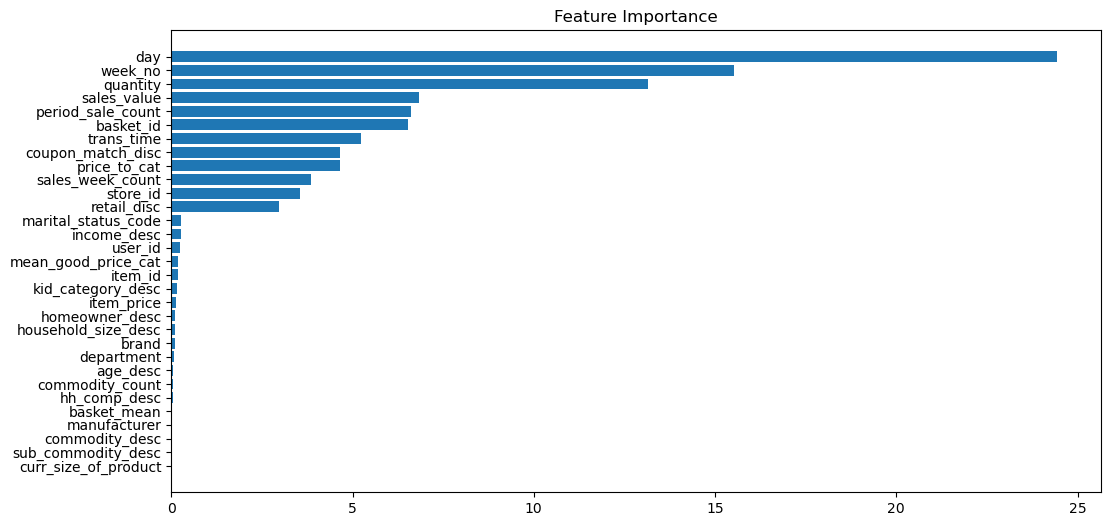

In [183]:
feature_importance = cat_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance')

In [247]:
X_test = data_val_lvl_2.copy()
X_test = X_test.merge(item_features, on='item_id', how='left')
X_test = X_test.merge(user_features, on='user_id', how='left')
X_test = gen_new_user_feachs(X_test)
X_test = gen_new_item_feachs(X_test)
X_test = X_test[other_feats + cat_feats]
X_test.fillna(7777777, inplace=True)
X_test['store_id'] = X_test['store_id'].astype('str')
X_test[cat_feats] = X_test[cat_feats].astype('category')
X_test.head(2)

/var/folders/7c/j0zz_mjs2tn_hc13hmvprwhh0000gn/T/ipykernel_9972/4177870387.py:11: RuntimeWarning: invalid value encountered in double_scalars
  apply(lambda row: row['sales_value']/row['item_price'], axis=1)


,user_id,item_id,basket_id,day,quantity,sales_value,retail_disc,trans_time,week_no,coupon_match_disc,...,commodity_desc,sub_commodity_desc,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,curr_size_of_product
0,338,840173,41260573635,636,1,1.99,0.0,1.12,92,0.0,...,GREETING CARDS/WRAP/PARTY SPLY,CARDS SEASONAL,7777777,7777777,7777777,7777777,7777777,7777777,7777777,
1,338,1037348,41260573635,636,1,0.89,-0.3,1.12,92,0.0,...,FRUIT - SHELF STABLE,PEACHES,7777777,7777777,7777777,7777777,7777777,7777777,7777777,15 OZ


In [249]:
y_pred_proba = cat_model.predict_proba(X_test)

In [224]:
train_users_lvl2 = targets_lvl_2['user_id'].unique()
train_users_lvl2

array([2070, 2021, 1753, ...,  436, 1697, 1745])

In [231]:
def get_xgb_rec(uid, df=data_val_lvl_2):
    return df[df['user_id']==uid].\
                sort_values('own_proba', ascending=False).head(5).item_id.to_list()

In [251]:
data_val_lvl_2['own_proba'] = y_pred_proba[:,1]
data_val_lvl_2['own_proba'].describe()

count    115989.000000
mean          0.999901
std           0.000097
min           0.997346
25%           0.999879
50%           0.999914
75%           0.999940
max           0.999976
Name: own_proba, dtype: float64

In [232]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


In [233]:
train_users_2 = users_lvl_2['user_id'].unique()
result_lvl_2 = result_lvl_2[result_lvl_2['user_id'].isin(train_users_2)]


In [234]:
result_lvl_2['own'] = result_lvl_2['user_id'].apply(lambda x: 
                                                          recommender.get_own_recommendations(x, N=100))
result_lvl_2.head(3)

,user_id,actual,own
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[856942, 9297615, 5577022, 9655212, 1124029, 8..."
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[13003092, 972416, 1084036, 995598, 5569792, 1..."
2,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[9338009, 939681, 974548, 894360, 1136033, 557..."


In [235]:
result_lvl_2['xgb_candidates'] = result_lvl_2['user_id'].apply(lambda x: 
                                                          get_xgb_rec(x))
result_lvl_2.head(3)

,user_id,actual,own,xgb_candidates
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[856942, 9297615, 5577022, 9655212, 1124029, 8...","[1031190, 1074612, 917704, 8293439, 9297615]"
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[13003092, 972416, 1084036, 995598, 5569792, 1...","[997284, 946489, 1100691, 1047193, 1123407]"
2,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[9338009, 939681, 974548, 894360, 1136033, 557...","[1085476, 850841, 1117035, 966058, 12696020]"


In [236]:
prec_1lvl_model = result_lvl_2.apply(lambda row:
                        precision_at_k(row[f'own'], row['actual'], 5), axis=1).mean()

prec_2lvl_model = result_lvl_2.apply(lambda row: 
                        precision_at_k(row['xgb_candidates'], row['actual'], 5), axis=1).mean()

print(f'1-lvl model Precision is {prec_1lvl_model}\n2-lvl model Precision is {prec_2lvl_model}')

1-lvl model Precision is 0.1639686684073107
2-lvl model Precision is 0.9788250652741515


#### Test

In [237]:
data_test = pd.read_csv('data/retail_test1.csv')
# data_test = prefilter_items(data=data_test, take_n_popular=7000, item_features=item_features)
data_test.head(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,1340,41652823310,664,912987,1,8.49,446,0.0,52,96,0.0,0.0
1,588,41652838477,664,1024426,1,6.29,388,0.0,8,96,0.0,0.0
2,2070,41652857291,664,995242,5,9.10,311,-0.6,46,96,0.0,0.0
3,1602,41665647035,664,827939,1,7.99,334,0.0,1741,96,0.0,0.0
4,1602,41665647035,664,927712,1,0.59,334,-0.4,1741,96,0.0,0.0


In [238]:
data_test = data_test[data_test['user_id'].isin(common_users)]

data_test

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,1340,41652823310,664,912987,1,8.49,446,0.0,52,96,0.0,0.0
1,588,41652838477,664,1024426,1,6.29,388,0.0,8,96,0.0,0.0
2,2070,41652857291,664,995242,5,9.10,311,-0.6,46,96,0.0,0.0
3,1602,41665647035,664,827939,1,7.99,334,0.0,1741,96,0.0,0.0
4,1602,41665647035,664,927712,1,0.59,334,-0.4,1741,96,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
88729,98,41944918665,684,945779,2,2.00,421,0.0,1705,98,0.0,0.0
88730,98,41944918665,684,993617,2,2.00,421,0.0,1705,98,0.0,0.0
88731,98,41944918665,684,1128647,2,2.00,421,0.0,1705,98,0.0,0.0
88732,98,41944918665,684,9526886,2,0.60,421,0.0,1705,98,0.0,0.0


In [239]:
result_test = data_test.groupby('user_id')['item_id'].unique().reset_index()
result_test.columns=['user_id', 'actual']
result_test.head(2)

,user_id,actual
0,1,"[880007, 883616, 931136, 938004, 940947, 94726..."
1,6,"[956902, 960791, 1037863, 1119051, 1137688, 84..."


In [240]:
%%time 

k = 50
result_test['own'] = result_test['user_id'].apply(lambda x: 
                                    recommender.get_own_recommendations(x, k))

CPU times: user 5.96 s, sys: 412 ms, total: 6.37 s
Wall time: 6.59 s


In [245]:
result_test['xgb_candidates'] = result_test['user_id'].apply(lambda x: 
                                                          get_xgb_rec(x))
result_test.head(3)

,user_id,actual,own,xgb_candidates
0,1,"[880007, 883616, 931136, 938004, 940947, 94726...","[856942, 9297615, 5577022, 9655212, 1124029, 8...","[1031190, 1074612, 917704, 8293439, 9297615]"
1,6,"[956902, 960791, 1037863, 1119051, 1137688, 84...","[13003092, 972416, 1084036, 995598, 5569792, 1...","[997284, 946489, 1100691, 1047193, 1123407]"
2,7,"[847270, 855557, 859987, 863407, 895454, 90663...","[9338009, 939681, 974548, 894360, 1136033, 557...","[1085476, 850841, 1117035, 966058, 12696020]"


In [246]:
precision_k = result_test.apply(lambda row:
                        precision_at_k(row[f'own'], row['actual'], 5), axis=1).mean()

precision_k_xgb = result_test.apply(lambda row: 
                        precision_at_k(row['xgb_candidates'], row['actual'], 5), axis=1).mean()

precision_k, precision_k_xgb

(0.1460012026458208, 0.16678693124874724)